In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json

### Load resuls and samples from run

In [3]:
y_test_pred = np.load('DQR/y_test_pred_joint_300s.npy')
y_test_mean = np.load('DQR/y_test_mean_300s.npy')
y_test_std = np.load('DQR/y_test_std_300s.npy')
y_test = np.load('DQR/y_test_300s.npy')
y_pred_s = np.load('DQR/y_test_pred_joint_samples_300s.npy')

In [12]:
a = (y_test.squeeze() * y_test_std + y_test_mean)[:, 0, :].sum(1)

In [11]:
b = (y_test_pred[..., 0].squeeze() * y_test_std + y_test_mean)[:, 0, :].sum(1)

In [16]:
np.sqrt(np.mean((a - b)**2))

152.7541766273885

In [21]:
eval_quantiles = [0.025, 0.975, 0.05, 0.95, 0.1, 0.9, 0.2, 0.8, 0.4, 0.6]
pred_ints =      [0.95,         0.90,       0.80,     0.60,     0.20    ]

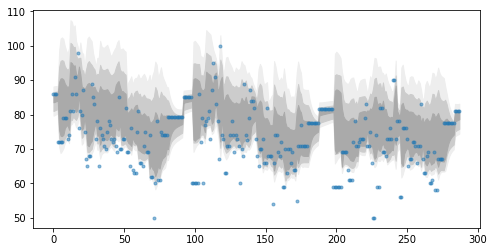

In [17]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=1, sharey=True)

ln = 2
n = 4*24*3
o = 4*24*3 - 16
ax.fill_between(np.arange(n), y_test_pred[o:o+n,0,ln,0,2]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], y_test_pred[o:o+n,0,ln,0,9]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], color='#eeeeee')
ax.fill_between(np.arange(n), y_test_pred[o:o+n,0,ln,0,3]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], y_test_pred[o:o+n,0,ln,0,8]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], color='#cccccc')
ax.fill_between(np.arange(n), y_test_pred[o:o+n,0,ln,0,4]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], y_test_pred[o:o+n,0,ln,0,7]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], color='#aaaaaa')
plt.plot(y_test[o:o+n,0,ln,0,0]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], marker='.', linestyle='', alpha=.5, )
#plt.plot(y_test_pred[o:o+n,0,ln,0,0]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], marker='', linestyle='-', alpha=1)
plt.savefig('plot3.png', bbox_inches='tight', dpi=300)

Test that mean and mean of samples are rougly the same

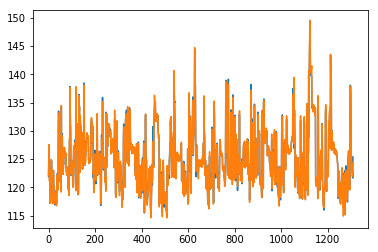

In [18]:
plt.plot(y_test_pred[:, 0, 0, 0, 0]*y_test_std[:,0,0]+y_test_mean[:,0,0])
plt.plot(np.mean(y_pred_s[:, 0, 0, :], axis=1))

In [25]:
y_pred_mean_back.shape

(1309, 3, 39)

In [26]:
start_lnk = 0
add_lnks = [1, 5, 10, 20, 30, 39]
t_out = [15, 30, 45]
y_pred_mean = y_test_pred[..., 0, 0]
y_test_back = np.squeeze(y_test) * y_test_std + y_test_mean
y_pred_mean_back = y_pred_mean * y_test_std + y_test_mean
preds = 3

res_dict = {}
for t in range(preds):
    print(f"Predicting for t + {t_out[t]} minutes")
    res_dict[f"t_{t_out[t]}"] = {}
    for add in add_lnks:
        print(f"\tSumming over {add} links")
        res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"] = {}
        links = np.arange(start_lnk, start_lnk+add).astype(int) if add != 100 else np.arange(100)
        for p, pred in enumerate(pred_ints):    
            print(f"\t\tQuantiles [{eval_quantiles[2*p]}, {eval_quantiles[2*p+1]}]")
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred] = {}

            y_test_lnks = np.sum(y_test_back[:, t, links], axis=1)
            y_pred_s_lnks = np.sum(y_pred_s[:, t, links, :], axis=1)
            
            q1 = np.quantile(y_pred_s_lnks, eval_quantiles[2*p], axis=1)
            q2 = np.quantile(y_pred_s_lnks, eval_quantiles[2*p+1], axis=1)
                    
  
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'ICP'] = np.mean(np.logical_and(y_test_lnks > q1, y_test_lnks < q2))
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'MIL'] = np.sum(np.maximum(0, q2 - q1)) / len(y_test)
            res_dict[f"t_{t_out[t]}"][f"nlinks_{add}"][pred][f'RMSE'] = np.sqrt(np.mean((y_pred_mean_back[:,t,links].sum(axis=1) - y_test_back[:,t,links].sum(axis=1))**2))
            

with open('DQR/results_joint.json', 'w') as fp:
    json.dump(res_dict, fp)


Predicting for t + 15 minutes
	Summing over 1 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
	Summing over 5 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
	Summing over 10 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
	Summing over 20 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
	Summing over 30 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
	Summing over 39 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Quantiles [0.1, 0.9]
		Quantiles [0.2, 0.8]
		Quantiles [0.4, 0.6]
Predicting for t + 30 minutes
	Summing over 1 links
		Quantiles [0.025, 0.975]
		Quantiles [0.05, 0.95]
		Qu

In [27]:
preds = ['t_15', 't_30', 't_45']
nlinks = 'nlinks_39'

for q, q_value in enumerate(pred_ints):
    print(f"{int(np.round(q_value*100,0))}\\% ", end='')
    for p, p_label in enumerate(preds):
        
        icp=res_dict[p_label][nlinks][q_value]['ICP']
        mil=res_dict[p_label][nlinks][q_value]['MIL']
        rmse = res_dict[p_label][nlinks][q_value]['RMSE']        
        if p > 0:
            print(" "*5, end="")
        print(f"& {int(np.round(icp*100, 0))} \\% & {int(np.round(mil))} & ", end='')
        if q == 0:
            print("\multirow{5}{*}{" + f"{rmse:.2f}" + "}", end='')
        if p < 2:
            print()
    if q < 4:
        print(" \\\\ \cline{1-3} \cline{5-6} \cline{8-9}")
    else:
        print(" \\\\ \hline")

95\% & 94 \% & 591 & \multirow{5}{*}{152.75}
     & 92 \% & 591 & \multirow{5}{*}{164.58}
     & 92 \% & 591 & \multirow{5}{*}{168.91} \\ \cline{1-3} \cline{5-6} \cline{8-9}
90\% & 89 \% & 498 & 
     & 86 \% & 498 & 
     & 86 \% & 498 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
80\% & 79 \% & 389 & 
     & 77 \% & 388 & 
     & 77 \% & 388 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
60\% & 64 \% & 256 & 
     & 61 \% & 255 & 
     & 58 \% & 255 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
20\% & 29 \% & 77 & 
     & 25 \% & 77 & 
     & 21 \% & 77 &  \\ \hline


95\% & 93 \% & 592 & \multirow{5}{*}{21.66}
     & 92 \% & 591 & \multirow{5}{*}{22.16}
     & 92 \% & 592 & \multirow{5}{*}{22.47} \\ \cline{1-3} \cline{5-6} \cline{8-9}
90\% & 88 \% & 499 & 
     & 86 \% & 497 & 
     & 86 \% & 498 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
80\% & 79 \% & 389 & 
     & 76 \% & 389 & 
     & 77 \% & 388 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
60\% & 62 \% & 256 & 
     & 60 \% & 256 & 
     & 60 \% & 255 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
20\% & 24 \% & 77 & 
     & 25 \% & 77 & 
     & 21 \% & 77 &  \\ \hline